In [1]:
import gym

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json
import math
import random
import numpy as np
import scipy as sp
import scipy.stats as st
import scipy.integrate as integrate
from scipy.stats import multivariate_normal
from sklearn import linear_model
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
import statsmodels.api as sm
from matplotlib.colors import LogNorm
import pickle
from tqdm import tqdm
from joblib import Parallel, delayed
import multiprocessing
from collections import namedtuple
from itertools import count
#from numba import jit
import copy
import cProfile
from datetime import datetime

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.autograd import Variable
sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15,8)
legend_fontsize = 16


/Users/workhard/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
N_ROWS, N_COLS, N_WIN = 3, 3, 3

class TicTacToe(gym.Env):
    def __init__(self, n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN):
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.n_win = n_win

        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.gameOver = False
        self.boardHash = None
        # ход первого игрока
        self.curTurn = 1
        self.emptySpaces = None
        
        self.reset()

    def getEmptySpaces(self):
        if self.emptySpaces is None:
            res = np.where(self.board == 0)
            self.emptySpaces = np.array([ (i, j) for i,j in zip(res[0], res[1]) ])
        return self.emptySpaces

    def makeMove(self, player, i, j):
        self.board[i, j] = player
        self.emptySpaces = None
        self.boardHash = None

    def getHash(self):
        if self.boardHash is None:
            self.boardHash = ''.join(['%s' % (x+1) for x in self.board.reshape(self.n_rows * self.n_cols)])
        return self.boardHash

    def isTerminal(self):
        # проверим, не закончилась ли игра
        cur_marks, cur_p = np.where(self.board == self.curTurn), self.curTurn
        for i,j in zip(cur_marks[0], cur_marks[1]):
#             print((i,j))
            win = False
            if i <= self.n_rows - self.n_win:
                if np.all(self.board[i:i+self.n_win, j] == cur_p):
                    win = True
            if not win:
                if j <= self.n_cols - self.n_win:
                    if np.all(self.board[i,j:j+self.n_win] == cur_p):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j <= self.n_cols - self.n_win:
                    if np.all(np.array([ self.board[i+k,j+k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j >= self.n_win-1:
                    if np.all(np.array([ self.board[i+k,j-k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if win:
                self.gameOver = True
                return self.curTurn

        if len(self.getEmptySpaces()) == 0:
            self.gameOver = True
            return 0

        self.gameOver = False
        return None

    def printBoard(self):
        for i in range(0, self.n_rows):
            print('----'*(self.n_cols)+'-')
            out = '| '
            for j in range(0, self.n_cols):
                if self.board[i, j] == 1:
                    token = 'x'
                if self.board[i, j] == -1:
                    token = 'o'
                if self.board[i, j] == 0:
                    token = ' '
                out += token + ' | '
            print(out)
        print('----'*(self.n_cols)+'-')

    def getState(self):
        return (self.getHash(), self.getEmptySpaces(), self.curTurn)

    def action_from_int(self, action_int):
        return ( int(action_int / self.n_cols), int(action_int % self.n_cols))

    def int_from_action(self, action):
        return action[0] * self.n_cols + action[1]
    
    def step(self, action):
        if self.board[action[0], action[1]] != 0:
            return self.getState(), -10, True, {}
        self.makeMove(self.curTurn, action[0], action[1])
        reward = self.isTerminal()
        self.curTurn = -self.curTurn
        return self.getState(), 0 if reward is None else reward, reward is not None, {}

    def reset(self):
        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.boardHash = None
        self.gameOver = False
        self.emptySpaces = None
        self.curTurn = 1
        
def plot_board(env, pi, showtext=True, verbose=True, fontq=20, fontx=60):
    '''Рисуем доску с оценками из стратегии pi'''
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    X, Y = np.meshgrid(np.arange(0, env.n_rows), np.arange(0, env.n_rows))
    Z = np.zeros((env.n_rows, env.n_cols)) + .01
    s, actions = env.getHash(), env.getEmptySpaces()
    if pi is not None and s in pi.Q:
        for i, a in enumerate(actions):
            Z[a[0], a[1]] = pi.Q[s][i]
    ax.set_xticks([])
    ax.set_yticks([])
    surf = ax.imshow(Z, cmap=plt.get_cmap('Accent', 10), vmin=-1, vmax=1)
    if showtext:
        for i,a in enumerate(actions):
            if pi is not None and s in pi.Q:
                ax.text( a[1] , a[0] , "%.3f" % pi.Q[s][i], fontsize=fontq, horizontalalignment='center', verticalalignment='center', color="w" )
#             else:
#                 ax.text( a[1] , a[0] , "???", fontsize=fontq, horizontalalignment='center', verticalalignment='center', color="w" )
    for i in range(env.n_rows):
        for j in range(env.n_cols):
            if env.board[i, j] == -1:
                ax.text(j, i, "O", fontsize=fontx, horizontalalignment='center', verticalalignment='center', color="w" )
            if env.board[i, j] == 1:
                ax.text(j, i, "X", fontsize=fontx, horizontalalignment='center', verticalalignment='center', color="w" )
    cbar = plt.colorbar(surf, ticks=[0, 1])
    ax.grid(False)
    plt.show()

def get_and_print_move(env, pi, s, actions, random=False, verbose=True, fontq=20, fontx=60):
    '''Делаем ход, рисуем доску'''
    plot_board(env, pi, fontq=fontq, fontx=fontx)
    if verbose and (pi is not None):
        if s in pi.Q:
            for i,a in enumerate(actions):
                print(i, a, pi.Q[s][i])
        else:
            print("Стратегия не знает, что делать...")
    if random:
        return np.random.randint(len(actions))
    else:
        return pi.getActionGreedy(s, len(actions))
    
def plot_test_game(env, pi1, pi2, random_crosses=False, random_naughts=True, verbose=True, fontq=20, fontx=60):
    '''Играем тестовую партию между стратегиями или со случайными ходами, рисуем ход игры'''
    done = False
    env.reset()
    while not done:
        s, actions = env.getHash(), env.getEmptySpaces()
        if env.curTurn == 1:
            a = get_and_print_move(env, pi1, s, actions, random=random_crosses, verbose=verbose, fontq=fontq, fontx=fontx)
        else:
            a = get_and_print_move(env, pi2, s, actions, random=random_naughts, verbose=verbose, fontq=fontq, fontx=fontx)
        observation, reward, done, info = env.step(actions[a])
        if reward == 1:
            print("Крестики выиграли!")
            plot_board(env, None, showtext=False, fontq=fontq, fontx=fontx)
        if reward == -1:
            print("Нолики выиграли!")
            plot_board(env, None, showtext=False, fontq=fontq, fontx=fontx)

# Часть вторая
## Создадим и обучим DQN размерами 3х3 и 4х4

In [3]:
class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def store(self, exptuple):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = exptuple
        self.position = (self.position + 1) % self.capacity
       
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

In [4]:
class Network33(nn.Module):
    def __init__(self, layer_size=512):
        super().__init__()
        self.Conv1 = nn.Conv2d(in_channels=3, out_channels=layer_size, kernel_size=(3, 3))
        self.FC1 = nn.Linear(layer_size*4, 512)
        self.FC2 = nn.Linear(layer_size, 16)       
        
    def forward(self, x):
        x = F.relu(self.Conv1(x))
        x = torch.flatten(x, 1)
        x = F.relu(self.FC1(x))

        return self.FC2(x)

In [5]:
def stateToTorch(state):
    return torch.FloatTensor(np.array([(state == 1), (state == -1), (state == 0)]))



In [17]:
class TicTacToeDQN():
    def __init__(self, n_rows=3, n_cols=3, n_win=3, network=Network33, lr= 3e-4, gamma=1):
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.memSize=1_000_000
        self.env = TicTacToe(n_rows, n_cols, n_win)
        self.model_O = network()
        self.model_X = network()
        self.memory_X=ReplayMemory(self.memSize)
        self.memory_O=ReplayMemory(self.memSize)
        self.lr=lr
        self.optimizer_X=torch.optim.Adam(self.model_X.parameters(), lr=self.lr, weight_decay=1e-6)
        self.optimizer_O=torch.optim.Adam(self.model_O.parameters(), lr=self.lr, weight_decay=1e-6)
        self.prevActs={}; self.prevStates={-1:None,1:None}
        self.gamma = gamma
        
        self.batch_size = 256
        
        self.eps_init, self.eps_final, self.eps_decay = 0.9, 0.05, 100000
        self.num_step = 0
    
        
    def selectModel(self,curTurn):
        return self.model_X if curTurn==1 else self.model_O
    
    def selectOptim(self,curTurn):
        return self.optimizer_X if curTurn==1 else self.optimizer_O
    
    def selectMem(self,curTurn):
        return self.memory_X if curTurn==1 else self.memory_O
    
    
    
    def select_greedy_action(self, state, curTurn):
        return self.selectModel(curTurn)(torch.unsqueeze(state,0)).data.max(1)[1].view(1, 1)

    def select_action(self, state, curTurn):
        sample = random.random()
        
        eps_threshold = self.eps_final + (self.eps_init - self.eps_final) * math.exp(-1. * self.num_step / self.eps_decay)
        #eps_threshold= 0.7
        if sample > eps_threshold:
            return self.select_greedy_action(state, curTurn)
        else:
            return torch.tensor([[random.randrange(self.n_rows * self.n_cols)]], dtype=torch.int64)
        
    
    def run_episode(self, e=0, do_learning=True, greedy=False, render=False):
        self.env.reset()

        state, _, curTurn = self.env.getState()
        
        prevActs = {}
        prevStates = {-1: None, 1: None}

        done = False
        while not done:
            
            state_tensor=stateToTorch(copy.deepcopy(self.env.board))
            with torch.no_grad():
                if greedy:
                    actionNum = self.select_greedy_action(state_tensor, curTurn)
                else:
                    actionNum = self.select_action(state_tensor, curTurn)

            self.prevStates[curTurn] = state_tensor
            self.prevActs[curTurn] = actionNum
            action = self.env.action_from_int(torch.tensor(actionNum.item()))
            nextState, reward, done, _ = self.env.step(action)
            next_state, emptySpaces, curTurn = nextState
            next_state_tensor = stateToTorch(copy.deepcopy(self.env.board))

        
            
            if reward == -10:
                transition = (state_tensor, actionNum, next_state_tensor, torch.tensor([reward], dtype=torch.float32))
                self.selectMem(curTurn).store(transition)
            else:
                if reward == -curTurn:
                        transition = (self.prevStates[-curTurn], self.prevActs[-curTurn], next_state_tensor, torch.tensor([1], dtype=torch.float32))
                        self.selectMem(-curTurn).store(transition)
                        
                if self.prevStates[curTurn] is not None:        
                    transition = (self.prevStates[curTurn], self.prevActs[curTurn], next_state_tensor, torch.tensor([reward * curTurn], dtype=torch.float32))
                    self.selectMem(curTurn).store(transition)


            if do_learning:
                self.learn(curTurn)

            state = next_state
            self.num_step += 1
            
    def learn(self, curTurn):
        if len(self.selectMem(curTurn)) < self.batch_size:
            return
        

        transitions = self.selectMem(curTurn).sample(self.batch_size)
        batch_state, batch_action, batch_next_state, batch_reward = zip(*transitions)

        batch_state = Variable(torch.stack(batch_state))
        batch_action = Variable(torch.cat(batch_action))
        batch_reward = Variable(torch.cat(batch_reward))
        batch_next_state = Variable(torch.stack(batch_next_state))
        
        # считаем значения функции Q
        Q = self.selectModel(curTurn)(batch_state).gather(1, batch_action).reshape([self.batch_size])
        

        Qmax = self.selectModel(curTurn)(batch_next_state).detach().max(1)[0]
        Qnext = batch_reward + (self.gamma * Qmax)
        # и хотим, чтобы Q было похоже на Qnext -- это и есть суть Q-обучения
        loss = F.smooth_l1_loss(Q, Qnext)
        self.selectOptim(curTurn).zero_grad()
        loss.backward()
        
        self.selectOptim(curTurn).step()
        
    def playDQN(self, side, play_episodes=500):
        rewards = []
        for i in range(play_episodes):
            self.env.reset()
            state, emptySpaces, curTurn = self.env.getState()
            done = False
            while not done:
                if curTurn == side:
                    actionNum = self.select_greedy_action(stateToTorch(copy.deepcopy(self.env.board)), side)
                    action = self.env.action_from_int(actionNum)
                else:
                    actionNum = np.random.choice(len(emptySpaces))
                    action = emptySpaces[actionNum]
                nextState, reward, done, _ = self.env.step(action)
                state, emptySpaces, curTurn = nextState
            if reward != -10:
                rewards.append(reward * side)
            else:
                if curTurn == side:
                    rewards.append(reward)
        return np.array(rewards)

100%|██████████| 25000/25000 [33:01<00:00, 12.61it/s]  


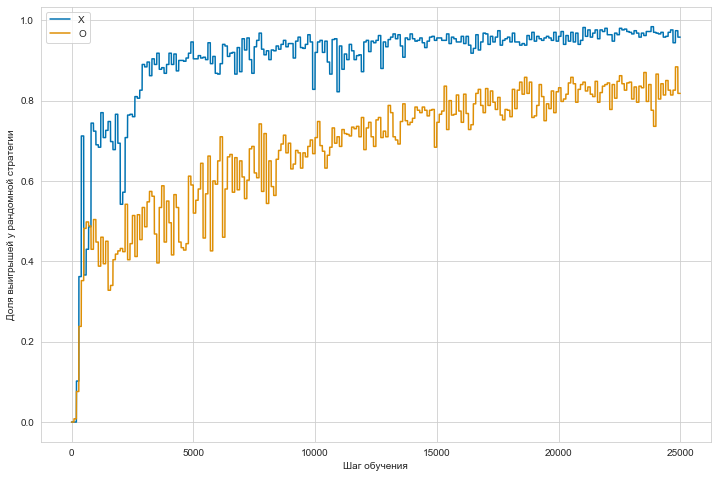

In [10]:
env = TicTacToeDQN(3,3,3, Network33, lr=1e-5, gamma=0.8)
learning_episodes = 25000
play_episodes = 500
crosses_mean_results = []
noughts_mean_results = []

for i in qdm(range(learning_episodes)):
    env.run_episode(do_learning=True)
    if i % 100 == 0:
        crosses = env.playDQN(1,play_episodes)
        noughts = env.playDQN(-1,play_episodes)
        crosses_mean_results.append(np.sum(crosses[crosses==1])/play_episodes)
        noughts_mean_results.append(np.sum(noughts[noughts==1])/play_episodes)
    else:
        crosses_mean_results.append(np.sum(crosses[crosses==1])/play_episodes)
        noughts_mean_results.append(np.sum(noughts[noughts==1])/play_episodes)
        
plt.figure(figsize=(12, 8))
plt.plot(range(len(crosses_mean_results)), crosses_mean_results, label='X')
plt.plot(range(len(crosses_mean_results)), noughts_mean_results, label='O')
plt.xlabel("Шаг обучения")
plt.ylabel("Доля выигрышей у рандомной стратегии")
plt.legend()

### То же самое для 4x4

In [15]:
class Network44(nn.Module):
    def __init__(self, layer_size=256):
        super().__init__()
        self.Conv1 = nn.Conv2d(in_channels=3, out_channels=layer_size, kernel_size=(3, 3))
        self.FC1 = nn.Linear(layer_size*4, layer_size)
        self.FC2 = nn.Linear(layer_size, 16)       
        
    def forward(self, x):
        x = F.relu(self.Conv1(x))
        x = torch.flatten(x, 1)
        x = F.relu(self.FC1(x))

        return self.FC2(x)

100%|██████████| 50000/50000 [1:39:41<00:00,  8.36it/s]  


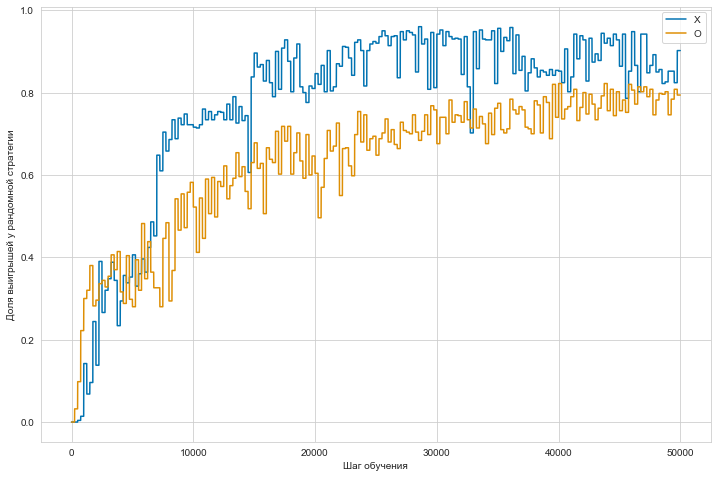

In [16]:
env = TicTacToeDQN(4,4,4, Network44, lr=1e-5, gamma=0.8)
learning_episodes = 50000
play_episodes = 500
crosses_mean_results = []
noughts_mean_results = []

for i in tqdm(range(learning_episodes)):
    env.run_episode(do_learning=True)
    if i % 250 == 0:
        crosses = env.playDQN(1,play_episodes)
        noughts = env.playDQN(-1,play_episodes)
        crosses_mean_results.append(np.sum(crosses[crosses==1])/play_episodes)
        noughts_mean_results.append(np.sum(noughts[noughts==1])/play_episodes)
    else:
        crosses_mean_results.append(np.sum(crosses[crosses==1])/play_episodes)
        noughts_mean_results.append(np.sum(noughts[noughts==1])/play_episodes)
        
plt.figure(figsize=(12, 8))
plt.plot(range(len(crosses_mean_results)), crosses_mean_results, label='X')
plt.plot(range(len(crosses_mean_results)), noughts_mean_results, label='O')
plt.xlabel("Шаг обучения")
plt.ylabel("Доля выигрышей у рандомной стратегии")
plt.legend()

### Создадим и обучим Dueling DQN 3x3

In [29]:
class DuelDQN33(nn.Module):
    def __init__(self, layer_size=512):
        super().__init__()
        self.Conv1 = nn.Conv2d(in_channels=3, out_channels=layer_size, kernel_size=(3, 3))
        self.FC1 = nn.Linear(layer_size, layer_size)
        self.V = nn.Linear(layer_size, 1)
        self.A = nn.Linear(layer_size, 9)
        
    def forward(self, x):
        x = F.relu(self.Conv1(x))
        x = torch.flatten(x, 1)
        x = F.relu(self.FC1(x))
        V=self.V(x)
        A=self.A(x)
        
        return V + (A - A.mean(1, keepdim=True))

100%|██████████| 25000/25000 [33:46<00:00, 12.34it/s]  


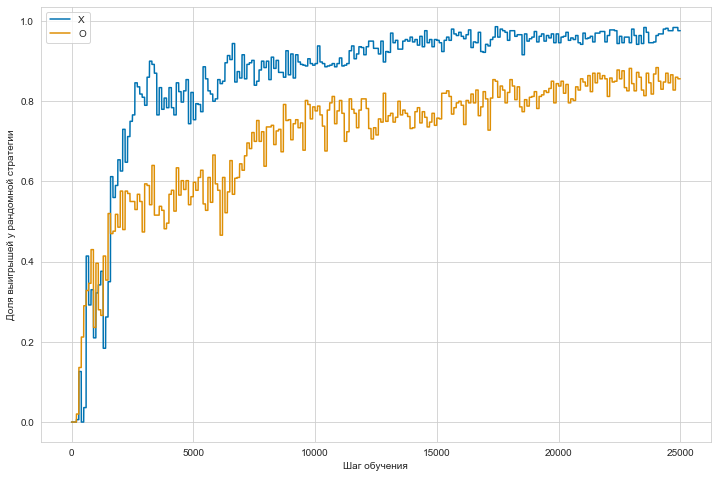

In [30]:
env = TicTacToeDQN(3,3,3, DuelDQN33, lr=1e-5, gamma=0.8)
learning_episodes = 25000
play_episodes = 500
crosses_mean_results = []
noughts_mean_results = []

for i in tqdm(range(learning_episodes)):
    env.run_episode(do_learning=True)
    if i % 100 == 0:
        crosses = env.playDQN(1,play_episodes)
        noughts = env.playDQN(-1,play_episodes)
        crosses_mean_results.append(np.sum(crosses[crosses==1])/play_episodes)
        noughts_mean_results.append(np.sum(noughts[noughts==1])/play_episodes)
    else:
        crosses_mean_results.append(np.sum(crosses[crosses==1])/play_episodes)
        noughts_mean_results.append(np.sum(noughts[noughts==1])/play_episodes)
        
plt.figure(figsize=(12, 8))
plt.plot(range(len(crosses_mean_results)), crosses_mean_results, label='X')
plt.plot(range(len(crosses_mean_results)), noughts_mean_results, label='O')
plt.xlabel("Шаг обучения")
plt.ylabel("Доля выигрышей у рандомной стратегии")
plt.legend()

### Создадим и обучим Dueling DQN 4x4

In [26]:
class DuelDQN44(nn.Module):
    def __init__(self, layer_size=256):
        super().__init__()
        self.Conv1 = nn.Conv2d(in_channels=3, out_channels=layer_size, kernel_size=(3, 3))
        self.FC1 = nn.Linear(layer_size*4, layer_size)
        self.V = nn.Linear(layer_size, 1)
        self.A = nn.Linear(layer_size, 16)
        
    def forward(self, x):
        x = F.relu(self.Conv1(x))
        x = torch.flatten(x, 1)
        x = F.relu(self.FC1(x))
        V=self.V(x)
        A=self.A(x)
        
        return V + (A - A.mean(1, keepdim=True))

100%|██████████| 50000/50000 [1:41:41<00:00,  8.19it/s]  


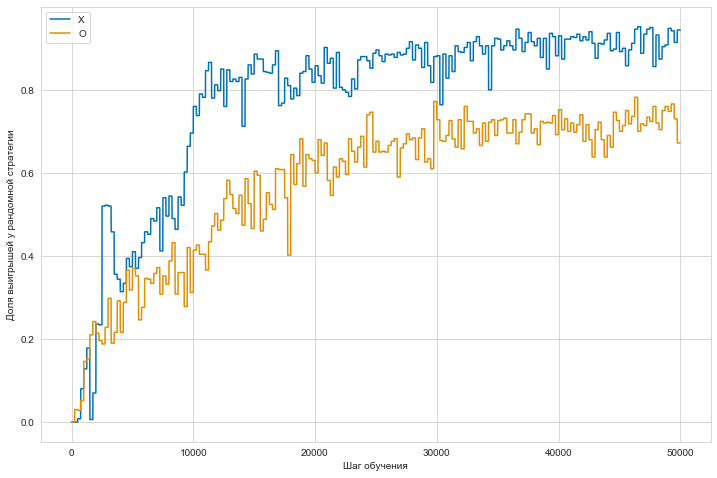

In [28]:
env = TicTacToeDQN(4,4,4, DuelDQN44, lr=1e-5, gamma=0.8)
learning_episodes = 50000
play_episodes = 500
crosses_mean_results = []
noughts_mean_results = []

for i in tqdm(range(learning_episodes)):
    env.run_episode(do_learning=True)
    if i % 250 == 0:
        crosses = env.playDQN(1,play_episodes)
        noughts = env.playDQN(-1,play_episodes)
        crosses_mean_results.append(np.sum(crosses[crosses==1])/play_episodes)
        noughts_mean_results.append(np.sum(noughts[noughts==1])/play_episodes)
    else:
        crosses_mean_results.append(np.sum(crosses[crosses==1])/play_episodes)
        noughts_mean_results.append(np.sum(noughts[noughts==1])/play_episodes)
        
plt.figure(figsize=(12, 8))
plt.plot(range(len(crosses_mean_results)), crosses_mean_results, label='X')
plt.plot(range(len(crosses_mean_results)), noughts_mean_results, label='O')
plt.xlabel("Шаг обучения")
plt.ylabel("Доля выигрышей у рандомной стратегии")
plt.legend()